In [1]:
from sklearn.datasets import fetch_openml
from sympy.printing.pretty.pretty_symbology import line_width

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

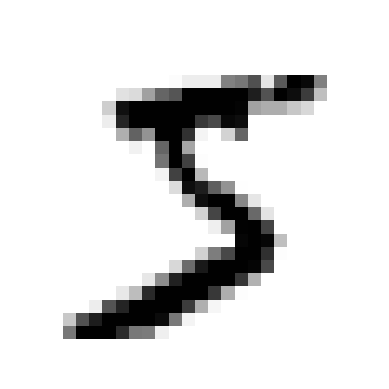

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.show()

plot_digit(X[0])

In [6]:
y[0]

'5'

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [10]:
y_train_5.shape, y_test_5.shape

((60000,), (10000,))

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_cls = SGDClassifier()
sgd_cls.fit(X_train, y_train_5)

SGDClassifier()

In [12]:
sgd_cls.predict([X[0]])

array([ True])

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9629 , 0.95915, 0.96805])

In [14]:
from sklearn.dummy import DummyClassifier
dummy_cls = DummyClassifier()
dummy_cls.fit(X_train, y_train_5)

DummyClassifier()

In [15]:
print(any(dummy_cls.predict(X_train)))

False


In [16]:
cross_val_score(dummy_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53840,   739],
       [ 1145,  4276]], dtype=int64)

In [19]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

precision, recall

(0.852642073778664, 0.7887843571296809)

In [20]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
f1

0.8194710617094673

In [21]:
decision_scores = sgd_cls.decision_function([X_train[0]])
decision_scores

array([2657.82289195])

In [22]:
y_scores = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3, method='decision_function')

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

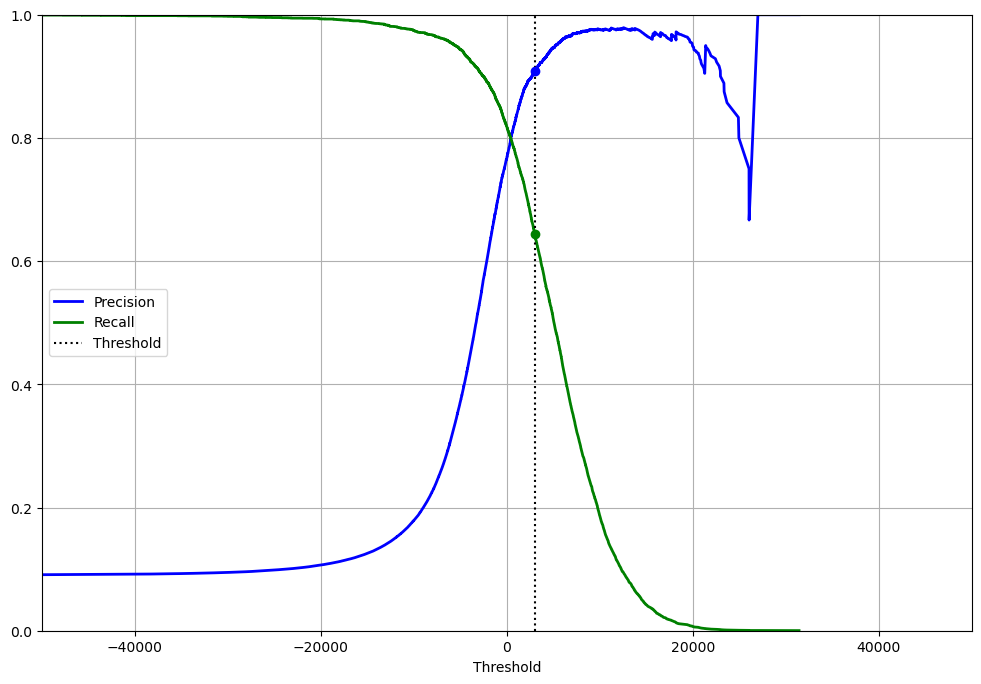

In [24]:
threshold = 3000
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b-", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='Threshold')
idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid(True)
plt.xlabel('Threshold')
plt.legend(loc="center left")
plt.show()

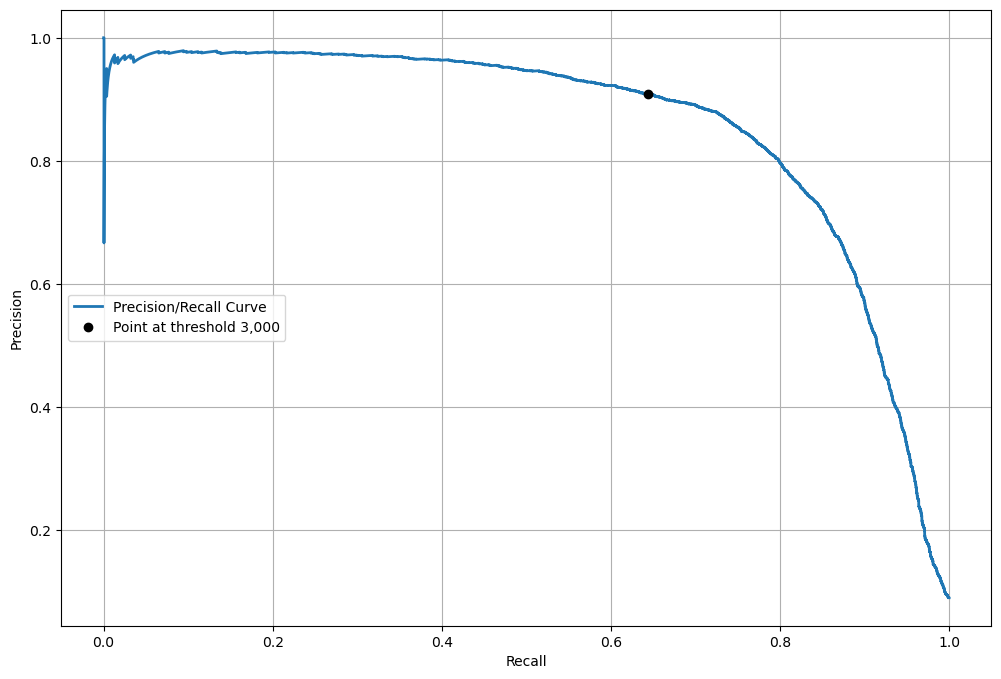

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall Curve')
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc="center left")
plt.show()

In [26]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

2701.6490771130957

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [28]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

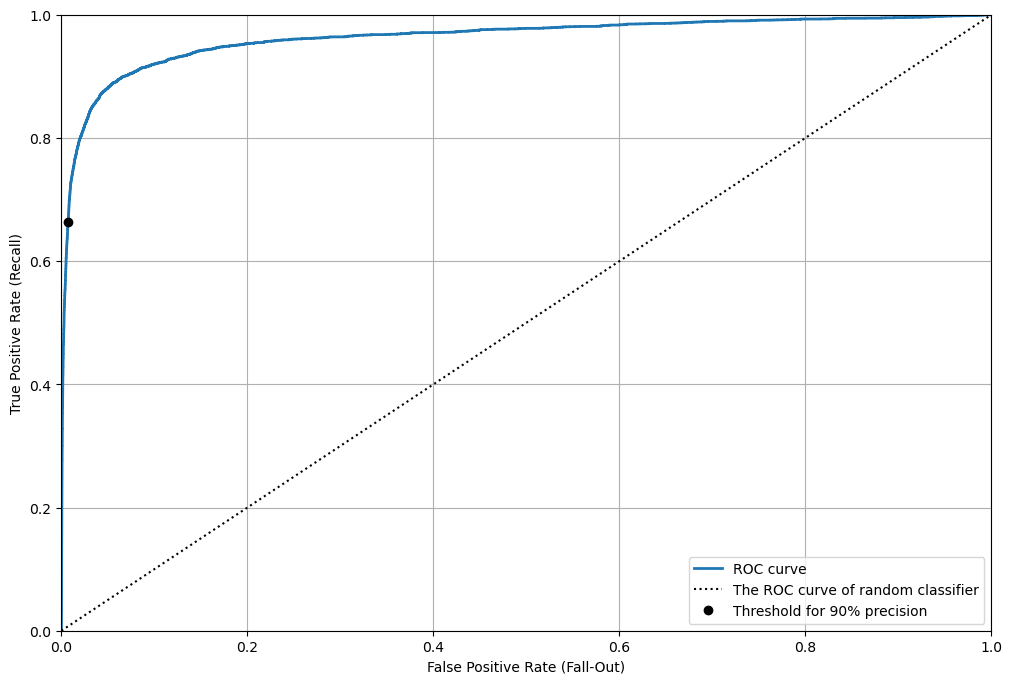

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label='The ROC curve of random classifier')
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9629225244085415

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(random_state=42)

In [32]:
y_probas_forest = cross_val_predict(forest_cls, X_train, y_train_5, cv=3, method='predict_proba')

In [33]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [34]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

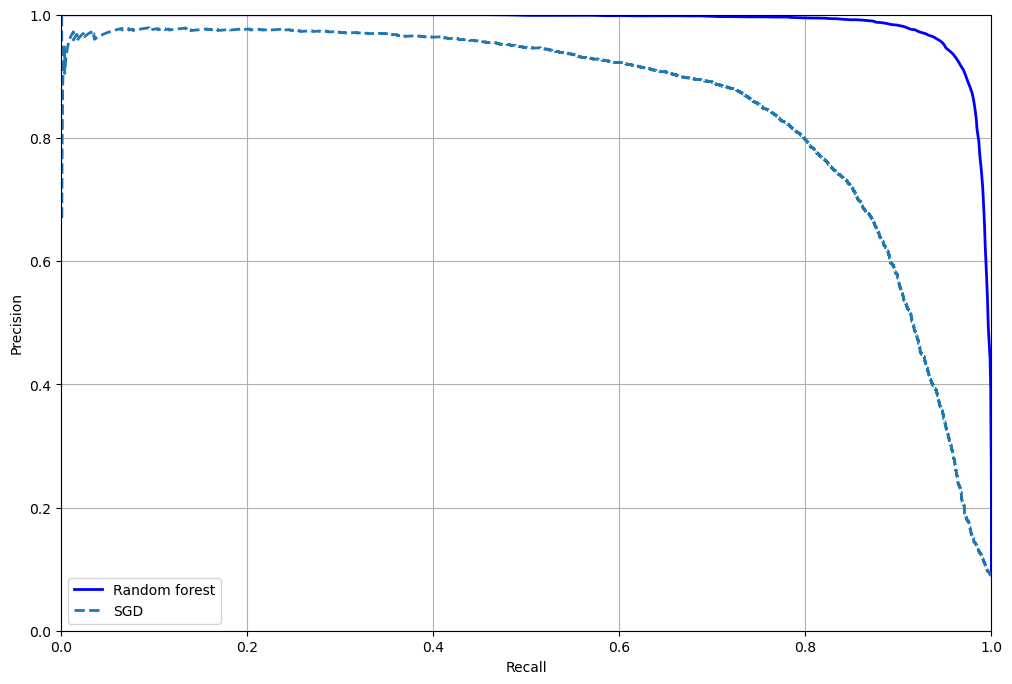

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

In [36]:
y_train_pred_forest = (y_scores_forest >= 0.5)
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
from sklearn.svm import SVC

svm_cls = SVC(random_state=42)
svm_cls.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [39]:
svm_cls.predict([X_train[0]])

array(['5'], dtype=object)

In [42]:
from sklearn.multiclass import OneVsRestClassifier

ovr_cls = OneVsRestClassifier(SVC(random_state=42))
ovr_cls.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [43]:
ovr_cls.predict([X_train[0]])

array(['5'], dtype='<U1')

In [45]:
sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(X_train, y_train)
sgd_cls.predict([X_train[0]])

array(['3'], dtype='<U1')